In [8]:
import pandas as pd
import numpy as np
import joblib
from joblib import dump, load
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import  Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalMaxPooling1D, Embedding, Conv1D, Flatten, Dense, Input
from keras.layers import Dropout, BatchNormalization, LSTM, Conv1D, MaxPooling1D, Bidirectional
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from sklearn.utils.class_weight import compute_class_weight

In [9]:
df = pd.read_csv("finaldataset.csv")
df.head()

,text,class
0,"Because today ends in a Y, Donald Trump took t...",0
1,With news circulating that Robert Mueller will...,0
2,Donald Trump s decision to end the Deferred Ac...,0
3,"GADSDEN, Ala. (Reuters) - In a U.S. Senate rac...",1
4,(Reuters) - Republicans in the U.S. Congress r...,1


In [10]:
df=df.dropna()
df=df.drop_duplicates()


In [11]:

# Downloading Necessary packages
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')
def preprocessing(text):

  # Step 1: Convert to lowercase
  text = text.lower()

  # Step 1: Convert to lowercase
  text = re.sub(r'[^a-zA-Z\s]','', text)

  # Step 3: Tokenize text
  tokens = word_tokenize(text)

  # Step 4: Remove stopwords
  stop_words = set(stopwords.words('english'))
  filtered_tokens = [token for token in tokens if token not in stop_words]
  

  # Step 6: Join tokens back into a single string
  preprocessed_text = ' '.join(filtered_tokens)
  return preprocessed_text

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\RESHMA\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\RESHMA\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\RESHMA\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\RESHMA\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [12]:
X = df['text']
X= list(X.apply(preprocessing))

In [13]:
X[0]

'today ends donald trump took twitter account bash group people time transgender americans series early morning tweets wednesday trump announced plans reinstate ban transgender individuals serving capacity us armed forces thus overturning obamaera rule trump decision stark contrast vow campaign last year said would better friend lgbtq community hillary clinton tell better friend day believe proven big league trump said timeaccording rand corporation transgender people serving militaryon wednesday retired navy seal team hero transgendered called trump decision ban trans people serving us military telling tell face worthy servingkristin beck yearveteran navy seals interviewed business insider trump ban choice words amateur president let meet face face tell worthy kristin beck said referring president bone spurs transgender matter service transgender affect anyone else beck continued liberty light defend everyone american citizen right beck deployed times two decades served bosnia iraq af

In [14]:
Y = np.array(list(df['class']))

In [15]:
Y

array([0, 0, 0, ..., 0, 0, 1])

In [16]:
x_train, x_test,y_train, y_test = train_test_split(X,Y,test_size=0.2,random_state=42)

In [18]:
word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(x_train)

X_train = word_tokenizer.texts_to_sequences(x_train)
X_test = word_tokenizer.texts_to_sequences(x_test)

In [21]:
vocab_length = len(word_tokenizer.word_index) + 1

vocab_length

29922

In [22]:
max_length = 100  # Specify the maximum length for padding
X_train = pad_sequences(X_train, maxlen=100, padding='post')
X_test = pad_sequences(X_test, maxlen=100, padding='post')

In [23]:
import pickle
with open('word_tokenizer.pkl', 'wb') as f:
    pickle.dump(word_tokenizer, f)
with open('x_test.pkl', 'wb') as f:
    pickle.dump(X_test, f)
with open('y_test.pkl', 'wb') as f:
    pickle.dump(y_test, f)

In [24]:
from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()
glove_file = open('glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [25]:
embedding_matrix = zeros((vocab_length, 100))
for word, index in word_tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [26]:
embedding_matrix.shape

(29922, 100)

In [27]:
model = Sequential() 
embedding_layer = Embedding(input_dim=vocab_length,
                            output_dim=100,
                            weights=[embedding_matrix],  #input_length=max_length
                            trainable=False)
model.add(embedding_layer)
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(max_length, 100)))
model.add(MaxPooling1D(pool_size=2))
model.add(Bidirectional(LSTM(256, return_sequences=True)))
model.add(LSTM(128, return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(64, return_sequences = True))
model.add(LSTM(32, return_sequences = True))
model.add(LSTM(16, return_sequences = False))
model.add(BatchNormalization())
model.add(Dense(8, activation = 'tanh'))
model.add(Dense(8, activation = 'tanh'))
model.add(Dense(4, activation = 'tanh'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid',kernel_regularizer=l2(0.001)))

# Model compiling
optimize=Adam(learning_rate=0.00004)
model.compile(optimizer=optimize, loss='binary_crossentropy', metrics=['accuracy'])
# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
# Create a ReduceLROnPlateau callback
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1) 

C:\Users\RESHMA\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [28]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │       2,992,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_4 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,992,200 (11.41 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,992,200 (11.41 MB)

In [29]:
from sklearn.utils.class_weight import compute_class_weight


class_weights = compute_class_weight(class_weight='balanced',
                                     classes=np.unique(y_train),
                                     y=y_train)

# Convert class_weights to dictionary format
class_weight_dict = dict(enumerate(class_weights))

In [30]:
class_weight_dict

{0: 1.0063131313131313, 1: 0.9937655860349127}

In [31]:
history = model.fit(
    X_train,
    y_train,
    batch_size=32,
    epochs=30,
    verbose=1,
    callbacks=[ reduce_lr,early_stopping],
    validation_data=(X_test, y_test),
    class_weight=class_weight_dict)

Epoch 1/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 48s 394ms/step - accuracy: 0.6092 - loss: 0.6597 - val_accuracy: 0.7368 - val_loss: 0.6757 - learning_rate: 4.0000e-05
Epoch 2/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 16s 313ms/step - accuracy: 0.7192 - loss: 0.5460 - val_accuracy: 0.9173 - val_loss: 0.6554 - learning_rate: 4.0000e-05
Epoch 3/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 16s 310ms/step - accuracy: 0.8158 - loss: 0.4922 - val_accuracy: 0.9273 - val_loss: 0.6181 - learning_rate: 4.0000e-05
Epoch 4/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 16s 313ms/step - accuracy: 0.8289 - loss: 0.4563 - val_accuracy: 0.9223 - val_loss: 0.5647 - learning_rate: 4.0000e-05
Epoch 5/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 15s 306ms/step - accuracy: 0.8559 - loss: 0.4162 - val_accuracy: 0.9298 - val_loss: 0.5259 - learning_rate: 4.0000e-05
Epoch 6/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 21s 318ms/step - accuracy: 0.8645 - loss: 0.4106 - val_accuracy: 0.8797 - val_loss: 0.4838 - learning_rate: 4.0000e-05
Epoch 7/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 16s 321ms/step - acc

In [32]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy:.2f}")

13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 0.9865 - loss: 0.1669
Test Accuracy: 0.99


In [33]:
model.save('model.h5')

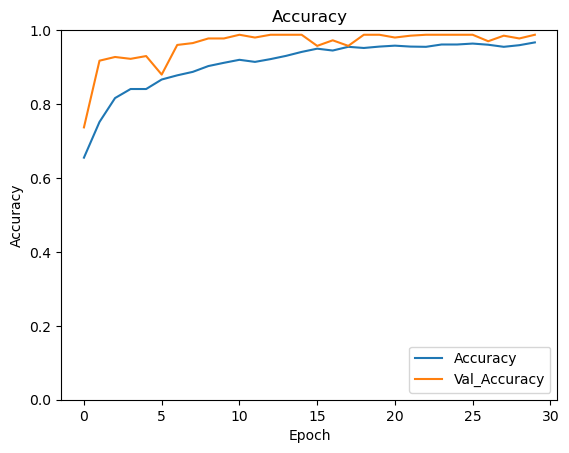

In [34]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'],label='Val_Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

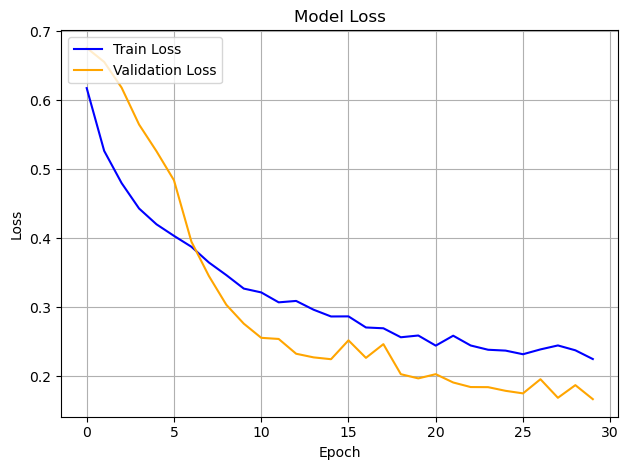

In [35]:
plt.title('Model Loss')
plt.plot(history.history['loss'], label='Train Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper left')
plt.grid(True)  # Add grid lines for better readability
# Show plots
plt.tight_layout()  # Adjust subplots to fit in the figure area.
plt.show()

In [63]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import numpy as np

# Load the trained model
from tensorflow.keras.models import load_model

model = load_model('model.h5')

# Make predictions on the test dataset
Y_pred_probs = model.predict(X_test)  # Probabilities
Y_pred_labels = (Y_pred_probs > 0.5).astype(int)  # Convert to binary labels

# Compute evaluation metrics
accuracy = accuracy_score(y_test, Y_pred_labels)
precision = precision_score(y_test, Y_pred_labels)
recall = recall_score(y_test, Y_pred_labels)
f1 = f1_score(y_test, Y_pred_labels)

# Print the evaluation results
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")



13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 326ms/step
Accuracy: 0.9875
Precision: 0.9895
Recall: 0.9843
F1-Score: 0.9869
